# <center>M2 DAC -   Reinforcement Learning & Advanced Deep</center>
##  <center> TME 9. Generative Adversarial Networks  </center>

Ce TME a pour objectif d'expérimenter les Generative Adversarial Networks (GANs) sur un problème de génération de visages. 

De manière classique, un GAN se formule selon un problème adverse de la manière suivante: 
$$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$$
Cette formulation met en jeu deux réseaux adverse: 
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les données réelles des données simulées  
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des données générées par $G$ est prouvée suivre la distribution des données réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par coeur les données d'apprentissage), mais l'objectif est d'approcher cette distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties sont difficilement distinguables des vraies données pour le discriminateur. 

Nous proposons de mettre ce genre d'architecture pour un la génération de visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à générer des visages qui paraissent les plus réalistes possibles tout en conservant une certaine diversité dans les distributions de sortie. Pour cela nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones convolutionnels (CNNs) pour le générateur et le discriminateur.    


 



Pour ce TP, nous vous proposons de travailler avec Google Colab qui est un service notebook en ligne avec ressources machines à disposition (nécessite d'être connecté à un compte google personnel):
*   https://colab.research.google.com/
*   Ouvrir ce Notebook avec "File>Upload Notebook"
*   Sélectionner un Runtime GPU : Runtime>Change Runtime Type (utile de le faire avant tout téléchargement de données car le changement de Runtime efface les données temporaires de la session)

Pour télécharger les données utiles au TP: 


*   Aller à l'adresse : https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8
*   Clic-droit sur CelebA, Ajouter à mon Drive
*   Exécuter le code ci-dessous (une autorisation vous sera demandée, suivre le lien donné à l'exécution pour obtenir le code d'authentification)

(Sinon vous pouvez aussi travailler en local en téléchargeant les données sur votre ordinateur mais attention fichier volumineux et colab propose des ressources GPU utiles à la résolution du TP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Vous devez maintenant avoir dans le paneau de gauche un onglet Files contenant un répertoire drive dans l'arborescence. C'est votre espace de stockage Google Drive. Il devrait contenir un répertoire CelebA (si ce n'est pas le cas attendre un peu et rafraichir, il peut mettre un certain temps à apparaître). 

Il s'agit maintenant de décompresser l'archive téléchargée (cela peut prendre jusqu'à une dizaine de minutes): 



In [ ]:
!unzip drive/My\ Drive/CelebA/Img/img_align_celeba -d data

Cela produit un répertoire data à la racine du repertoire temporaire de votre Google Colab. Ce repertoire contient un sous-repertoire img_align_celeba contenant une liste de 202599 fichiers jpg correspondant à des photos de visages de célébrités (attention ce repertoire est temporaire, tout ce qui n'est pas dans un drive est effacé à la fin de la session). 



In [4]:

import numpy as np
try:
    import torch
except:
    !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
try:
    import gdown
except:
    !pip install gdown
import os
import zipfile 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

In [17]:


## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = '/tempory/data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /tempory/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 111MB/s] 


Le code ci-dessous permet de déclarer la manière de charger les données. 

Lorsque des données sont demandées (pour la construction d'un nouveau batch par exemple), une série de transformations est appliquée sur les images, selon la composition de transformateurs déclarée pour le chargement: 
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch 
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type de 0.5.



In [4]:
image_size = 64
dataset = dset.ImageFolder(root = dataset_folder,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [5]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: /tempory/data/celeba/img_align_celeba
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Le code ci-dessous permet de déclarer la manière de charger les images et en affiche un échantillon. 

In [6]:
import matplotlib.pyplot as plt
import os



seed=0
torch.manual_seed(seed)
np.random.seed(seed)
device=0
if device>=0 and torch.cuda.is_available():
    
    cudnn.benchmark = True
    torch.cuda.device(device)
    torch.cuda.manual_seed(seed)
else: 
    device=-1

batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Affichage de quelques images
real_batch = next(iter(dataloader)) #real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)


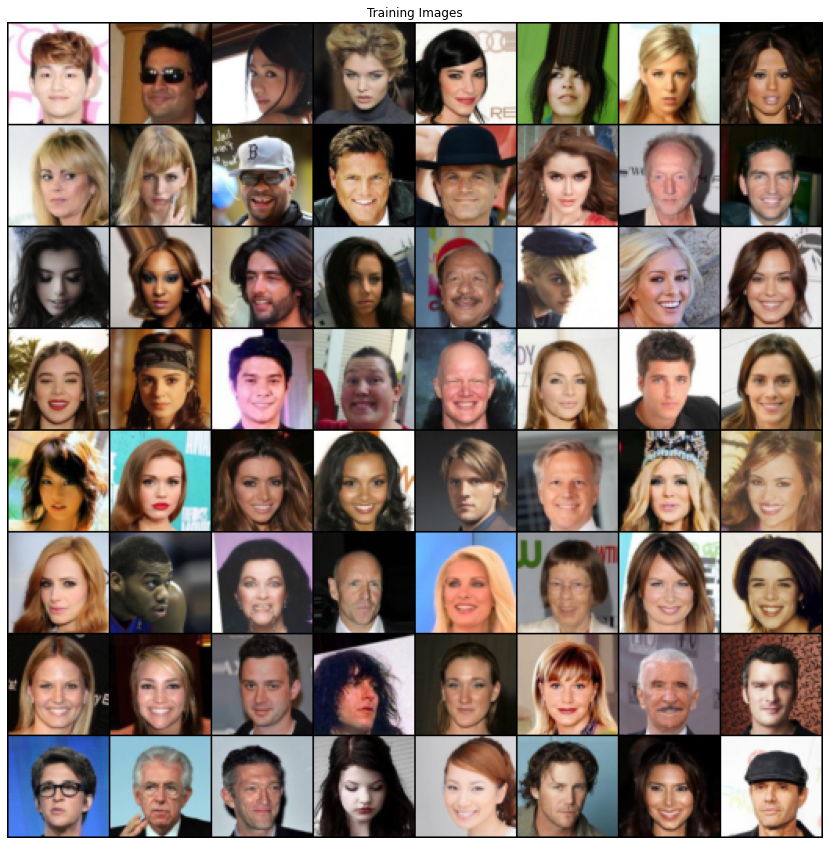

In [7]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
os.makedirs("./genFaces",exist_ok=True)
plt.savefig("./genFaces/train.png" )

Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D et activations RELU: 

In [8]:

nc = 3 # Nombre de canaux de l'entrée
ndf = 64 # Facteur du nombre de canaux de sortie des différentes couches de convolution


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
acc = 0
for param in netD.parameters():
    acc+= param.numel()
print(acc)

2765568


In [10]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
acc = 0
for param in netG.parameters():
    acc+= param.numel()
print(acc)

3576704


Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour chaque nouveau batch d'images, on alterne les deux mises à jour suivantes, selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale centrée réduite (un nouveau batch de $z$ à chaque itération): 

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:  $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour maximiser:  $log(D(G(z)))$ 


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne des sorties du discriminateur sur les images réelles et la moyenne des sorties du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du DataLoader), on pourra enregistrer les images générées à partir d'un batch de vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités du générateur.  



In [24]:
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
beta2= 0.999
g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
nb_epochs = 20
loss_fn = nn.BCELoss()

In [20]:
netD(torch.randn(100,3,64,64).cuda()).shape

torch.Size([100, 1, 1, 1])

In [21]:
netG().shape

torch.Size([64, 3, 64, 64])

In [25]:
g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch
        im = im.to(device)
        cur_batch_size = im.shape[0]  
        
        ############################################################################
        zero_label= torch.zeros(cur_batch_size, device = device)
        one_label = torch.ones(cur_batch_size, device = device)
        ############################################################################
        z = torch.randn(cur_batch_size, nz, 1, 1, device = device)
        fake_image = netG(z)
        yhat_real = netD(im).squeeze()
        yhat_fake = netD(fake_image.detach()).squeeze()
        ############################################################################
        real_loss = loss_fn(yhat_real, one_label)
        fake_loss = loss_fn(yhat_fake, zero_label)
        ############################################################################
        d_loss = (real_loss + fake_loss) / 2 
        d_opt.zero_grad()
        d_loss.backward() 
        d_opt.step()
        ############################################################################
        g_loss = loss_fn(netD(fake_image).squeeze(),one_label)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        ############################################################################
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        j += 1

it: 1582; g_loss: 2.200227737426758; d_loss: 0.5670695900917053; avg_real_score: 0.6112221479415894; avg_fake_score: 0.4066224992275238: : 1583it [01:41, 15.60it/s]   
it: 3165; g_loss: 1.0952821969985962; d_loss: 0.562675416469574; avg_real_score: 0.5447525382041931; avg_fake_score: 0.34991833567619324: : 1583it [01:42, 15.48it/s]  
it: 4748; g_loss: 0.7805147767066956; d_loss: 0.6877114176750183; avg_real_score: 0.41746246814727783; avg_fake_score: 0.3151731491088867: : 1583it [01:43, 15.31it/s]  
it: 6331; g_loss: 1.037519097328186; d_loss: 0.650000810623169; avg_real_score: 0.37159788608551025; avg_fake_score: 0.1860368251800537: : 1583it [01:44, 15.21it/s]    
it: 7914; g_loss: 1.6927496194839478; d_loss: 0.48570191860198975; avg_real_score: 0.6749402284622192; avg_fake_score: 0.40428251028060913: : 1583it [01:44, 15.10it/s] 
it: 9497; g_loss: 1.8328372240066528; d_loss: 0.4514581561088562; avg_real_score: 0.6738821864128113; avg_fake_score: 0.3660199046134949: : 1583it [01:41, 15

Le code ci-dessous applique votre réseau à un batch de $z$ aléatoires et affiche les images générées (et enregistre dans fake.png). 

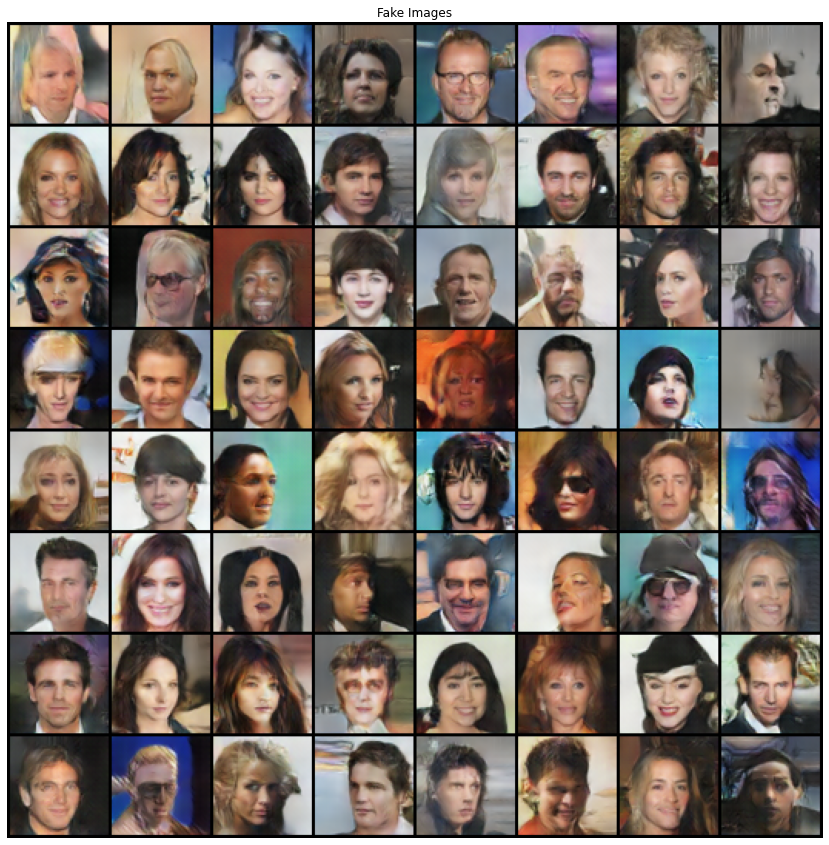

In [27]:
img_list = []
noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "./fake.png" )


Le générateur du papier original DCGAN possède en fait l'architecture suivante: 

![Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Comme le réseau $G$ définit plus haut, il correspond à un empilement de couches de convolutions transposées (appelée dans certains papiers couches de déconvolution). Contrairement aux convolutions classiques qui mènent à une réduction de la taille des sorties, les convolutions transposées agrandissent les cartes de caractéristiques considérées (feature maps). C'est particulièrement adapté pour de la génération d'images à partir d'un code de petite taille (ici $z$). 

 Pour comprendre comment fonctionne la convolution transposée, voici un exemple simple avec une entrée 2 x 2 et un noyau 2 x 2. Chaque élément de l'entrée (4 éléments) est multiplié par le noyau et le résultat est ajouté à la sorte de taille 3 x 3: 

![BasicTransposeConv2D](http://d2l.ai/_images/trans-conv.svg)

Et voici deux animations pour se représenter l'opération d'une manière plus générale. A gauche on utilise un stride de 1, à droite un stride de 2: 

<p align="center">
<img src="https://i.stack.imgur.com/YyCu2.gif">
<img src="https://i.stack.imgur.com/f2RiP.gif">
</p>


Suivant la doc Pytorch de torch.nn.ConvTranspose2d, la hauteur $H_{out}$ et la largeur $W_{out}$ des cartes de sortie du ConvTranspose2d peuvent se calculer de la manière suivante: 

$H_{out}$=($H_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

$W_{out}$=($W_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1


Proposer un nouveau réseau $G$ qui respecte l'architecture du schéma du papier DCGAN et comparer les résultats. On gardera le paramètre de dilation à sa valeur de 1 par défaut mais il est possible de moduler les valeurs de padding et output_padding pour obtenir des sorties de la taille désirée. 


In [48]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.proj_reshape = nn.Sequential(nn.Linear(nz, ngf * 16 * 4 ** 2), # (Batch, 1024*4*4) ensuite un reshape
                                          nn.Unflatten(1, (ngf * 16, 4, 4)))
        self.main = nn.Sequential(
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=5, stride=2, padding=2,output_padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=5, stride=2, padding=2,output_padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=5, stride=2, padding=2,output_padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=5, stride=2, padding=2,output_padding=1, bias=False),
            nn.Tanh())

    def forward(self, input):
        input = self.proj_reshape(input) 
        return self.main(input)
    
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (proj_reshape): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1024, 4, 4))
  )
  (main): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [49]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [50]:
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
beta2= 0.999
g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
nb_epochs = 20
loss_fn = nn.BCELoss()

In [51]:
g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch 
        im = im.to(device)
        cur_batch_size = im.shape[0]  
        
        ############################################################################
        zero_label= torch.zeros(cur_batch_size, device = device)
        one_label = torch.ones(cur_batch_size, device = device)
        ############################################################################
        z = torch.randn(cur_batch_size, nz, device = device)
        fake_image = netG(z)
        yhat_real = netD(im).squeeze()
        yhat_fake = netD(fake_image.detach()).squeeze()
        ############################################################################
        real_loss = loss_fn(yhat_real, one_label)
        fake_loss = loss_fn(yhat_fake, zero_label)
        ############################################################################
        d_loss = (real_loss + fake_loss) / 2 
        d_opt.zero_grad()
        d_loss.backward() 
        d_opt.step()
        ############################################################################
        g_loss = loss_fn(netD(fake_image).squeeze(),one_label)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        ############################################################################
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        j += 1

it: 1582; g_loss: 5.361717700958252; d_loss: 0.4751041531562805; avg_real_score: 0.8783560991287231; avg_fake_score: 0.5114418864250183: : 1583it [03:18,  7.96it/s]     
it: 3165; g_loss: 3.858191728591919; d_loss: 0.18326230347156525; avg_real_score: 0.793099582195282; avg_fake_score: 0.08820690959692001: : 1583it [03:21,  7.86it/s]     
it: 4748; g_loss: 4.089746475219727; d_loss: 0.27265506982803345; avg_real_score: 0.9295607209205627; avg_fake_score: 0.34818634390830994: : 1583it [03:23,  7.79it/s]   
it: 6331; g_loss: 2.0083041191101074; d_loss: 0.1892852783203125; avg_real_score: 0.7744444608688354; avg_fake_score: 0.0863494798541069: : 1583it [03:25,  7.70it/s]     
it: 7914; g_loss: 4.447251796722412; d_loss: 0.9291053414344788; avg_real_score: 0.9430801272392273; avg_fake_score: 0.7561824321746826: : 1583it [03:26,  7.65it/s]      
it: 9497; g_loss: 0.7753438949584961; d_loss: 0.8485735058784485; avg_real_score: 0.26145511865615845; avg_fake_score: 0.012909000739455223: : 1583

KeyboardInterrupt: 

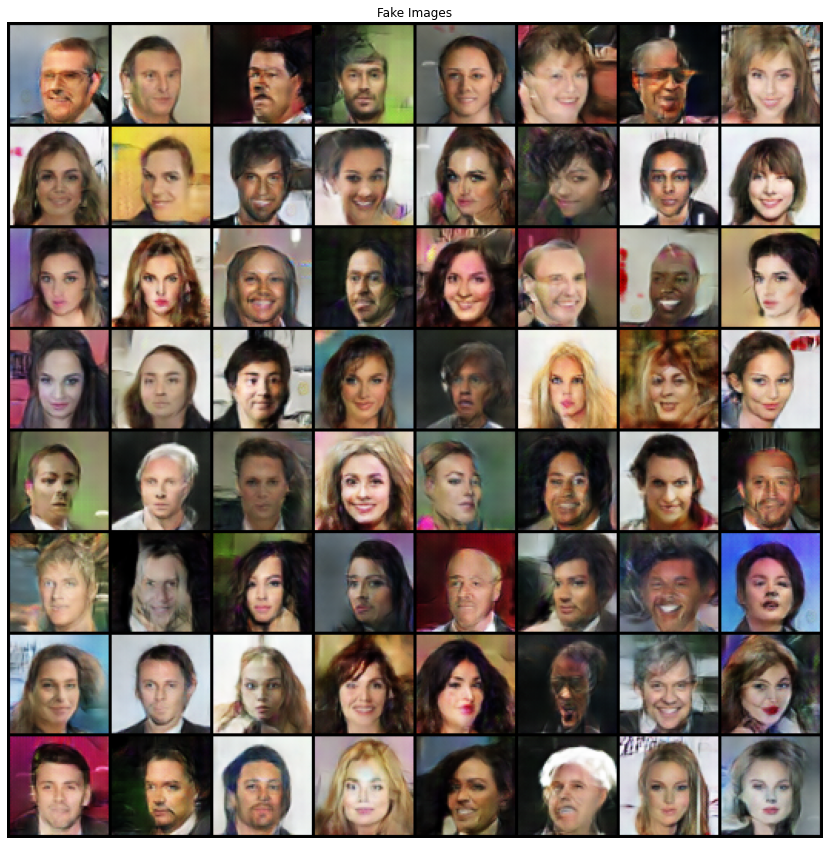

In [52]:
img_list = []
noise = torch.randn(64, nz, device=device)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "./fake_2.png" )

Bonus: Réaliser le même genre d'apprentissage sur le corpus Mnist (Dataloader existant dans torch pour télécharger et charger le corpus)

# MNIST

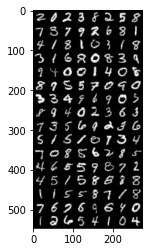

In [8]:
batch_size = 128
image_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 2 if device =='cuda' else 0
dataset = dset.MNIST(root = './data', download = True, transform=transforms.Compose([
                                                                 transforms.Resize(image_size),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5), (0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

real_batch, labels = next(iter(dataloader))
plt.imshow(transforms.ToPILImage()(vutils.make_grid(real_batch)))

In [14]:

nc = 1 # Nombre de canaux de l'entrée
ndf = 32 # Facteur du nombre de canaux de sortie des différentes couches de convolution


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input).squeeze() #(Batch,)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): Sigmoid()
  )
)


In [15]:
real_batch, labels = next(iter(dataloader))
netD(real_batch.to(device)).shape

torch.Size([128])

In [16]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 32 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, input):
        return self.main(input)
    
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [17]:
netG(torch.randn(128,nz,1,1, device = device)).shape

torch.Size([128, 1, 32, 32])

In [18]:
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
beta2= 0.999
g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
nb_epochs = 20
loss_fn = nn.BCELoss()

In [19]:
g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch 
        im = im.to(device)
        cur_batch_size = im.shape[0]  
        
        ############################################################################
        zero_label= torch.zeros(cur_batch_size, device = device)
        one_label = torch.ones(cur_batch_size, device = device)
        ############################################################################
        z = torch.randn(cur_batch_size, nz, 1, 1, device = device)
        fake_image = netG(z)
        yhat_real = netD(im)
        yhat_fake = netD(fake_image.detach())
        ############################################################################
        real_loss = loss_fn(yhat_real, one_label)
        fake_loss = loss_fn(yhat_fake, zero_label)
        ############################################################################
        d_loss = (real_loss + fake_loss) / 2 
        d_opt.zero_grad()
        d_loss.backward() 
        d_opt.step()
        ############################################################################
        g_loss = loss_fn(netD(fake_image),one_label)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        ############################################################################
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        j += 1

it: 468; g_loss: 3.135972499847412; d_loss: 0.049905210733413696; avg_real_score: 0.9373558759689331; avg_fake_score: 0.0322822742164135: : 469it [00:11, 39.55it/s]     
it: 937; g_loss: 1.580601692199707; d_loss: 0.37176817655563354; avg_real_score: 0.7635219097137451; avg_fake_score: 0.34749719500541687: : 469it [00:11, 40.44it/s]      
it: 1406; g_loss: 2.9972586631774902; d_loss: 0.19492654502391815; avg_real_score: 0.9154881834983826; avg_fake_score: 0.24673354625701904: : 469it [00:11, 40.45it/s]   
it: 1875; g_loss: 5.685924053192139; d_loss: 0.9996239542961121; avg_real_score: 0.9930542707443237; avg_fake_score: 0.837287425994873: : 469it [00:11, 40.30it/s]      
it: 2344; g_loss: 1.077845573425293; d_loss: 0.2457856684923172; avg_real_score: 0.695300817489624; avg_fake_score: 0.05852387845516205: : 469it [00:11, 40.15it/s]     
it: 2813; g_loss: 2.7753634452819824; d_loss: 0.1438065767288208; avg_real_score: 0.9002450704574585; avg_fake_score: 0.15502125024795532: : 469it [00:

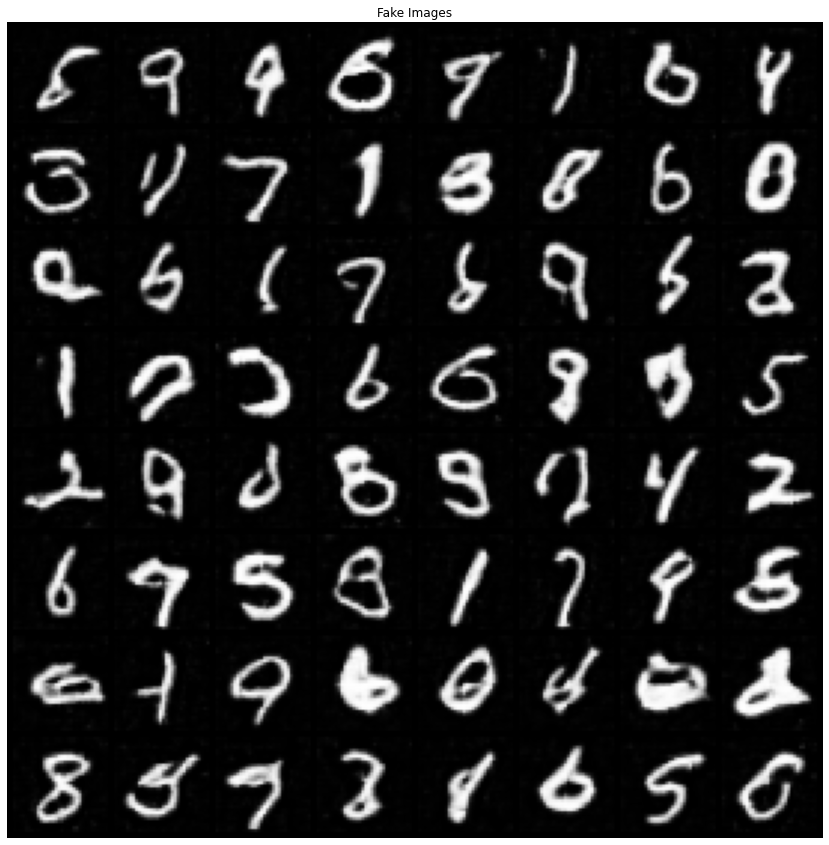

In [21]:
img_list = []
noise = torch.randn(64, nz,1,1, device=device)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "./fake_MNIST.png" )

# Upsample

In [29]:

nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 32 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution
nc = 1 # Nombre de canaux de l'entrée
ndf = 32 # Facteur du nombre de canaux de sortie des différentes couches de convolution
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lin = nn.Sequential(nn.Linear(nz, ngf * 4 * 4 ** 2))

        self.conv_ = nn.Sequential(
            nn.BatchNorm2d(ngf * 4),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 4, ngf * 4, 3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 4, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 4, ngf * 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 2, nc, 3, stride=1, padding=1),
            nn.Tanh())

    def forward(self, z):
        x = self.lin(z)
        x = x.view(x.shape[0], 128, 4, 4)
        x = self.conv_(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf // 2, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf // 2, ndf, 3, 2, 1),
            nn.BatchNorm2d(ndf, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1),
            nn.BatchNorm2d(ndf * 2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),   
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1),
            nn.BatchNorm2d(ndf * 4, 0.8),
            nn.LeakyReLU(0.2, inplace=True))

        ds_size = ndf // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.shape[0], -1)
        probs = self.adv_layer(x)
        return probs.squeeze()


In [36]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)
real_batch, labels = next(iter(dataloader))
netD(real_batch.to(device)).shape

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

torch.Size([128])

In [37]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)
netG(torch.randn(128,nz, device = device)).shape

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


torch.Size([128, 1, 32, 32])

In [38]:
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
beta2= 0.999
g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
nb_epochs = 20
loss_fn = nn.BCELoss()

In [39]:
g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch 
        im = im.to(device)
        cur_batch_size = im.shape[0]  
        
        ############################################################################
        zero_label= torch.zeros(cur_batch_size, device = device)
        one_label = torch.ones(cur_batch_size, device = device)
        ############################################################################
        z = torch.randn(cur_batch_size, nz, device = device)
        fake_image = netG(z)
        yhat_real = netD(im)
        yhat_fake = netD(fake_image.detach())
        ############################################################################
        real_loss = loss_fn(yhat_real, one_label)
        fake_loss = loss_fn(yhat_fake, zero_label)
        ############################################################################
        d_loss = (real_loss + fake_loss) / 2 
        d_opt.zero_grad()
        d_loss.backward() 
        d_opt.step()
        ############################################################################
        g_loss = loss_fn(netD(fake_image),one_label)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        ############################################################################
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        j += 1

it: 468; g_loss: 0.697786271572113; d_loss: 0.6935993432998657; avg_real_score: 0.49830731749534607; avg_fake_score: 0.49869948625564575: : 469it [00:18, 24.86it/s] 
it: 937; g_loss: 0.6942799091339111; d_loss: 0.6784682273864746; avg_real_score: 0.5195450782775879; avg_fake_score: 0.5001481175422668: : 469it [00:19, 24.39it/s]  
it: 1406; g_loss: 0.7923116683959961; d_loss: 0.6983107924461365; avg_real_score: 0.5191935300827026; avg_fake_score: 0.5131649374961853: : 469it [00:19, 24.45it/s]  
it: 1875; g_loss: 0.773259162902832; d_loss: 0.6532660126686096; avg_real_score: 0.47388288378715515; avg_fake_score: 0.4069623351097107: : 469it [00:19, 24.34it/s]  
it: 2344; g_loss: 0.8066643476486206; d_loss: 0.5562807321548462; avg_real_score: 0.6061381697654724; avg_fake_score: 0.4380769729614258: : 469it [00:19, 24.56it/s]  
it: 2813; g_loss: 0.7337934970855713; d_loss: 0.6287816762924194; avg_real_score: 0.5644047260284424; avg_fake_score: 0.47102540731430054: : 469it [00:19, 24.35it/s] 


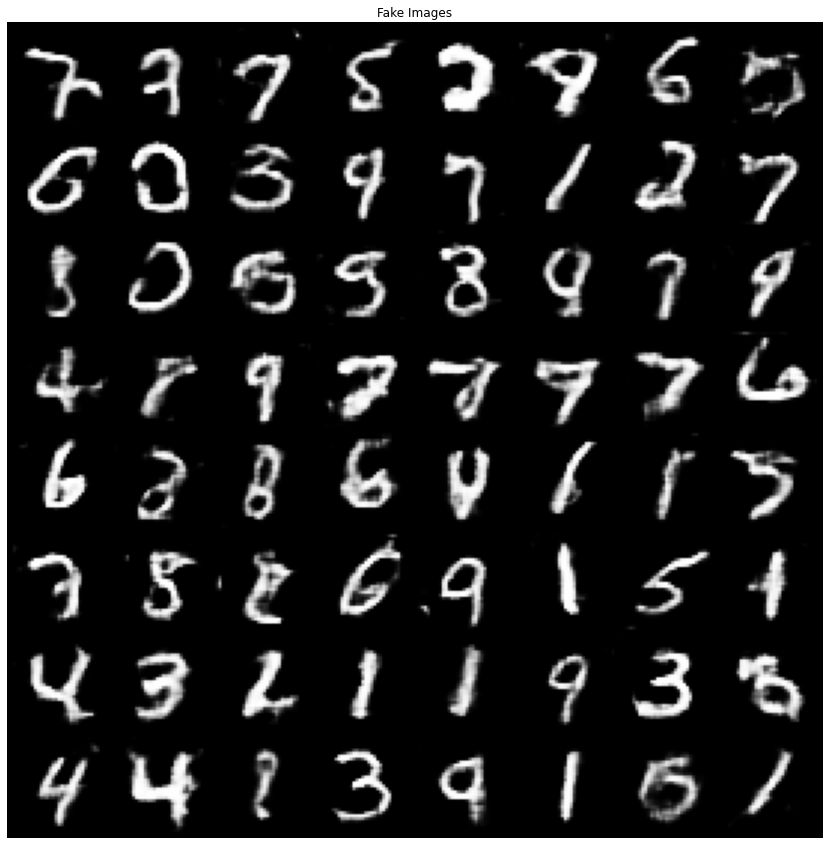

In [41]:
img_list = []
noise = torch.randn(64, nz, device=device)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "./fake_MNIST_upsample.png" )